# Lecture 19: Parallelism

## CS4787 — Principles of Large-Scale Machine Learning Systems

In [1]:
using PyPlot
using LinearAlgebra
using Statistics

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/cdesa/.julia/packages/PyPlot/4wzW1/src/init.jl:192


So far we've been talking about **optimization algorithms** to train machine learning models efficiently, and ways that we can use **statistical subsampling** to make them more efficient.

We made repeated use of the first two **principles of scalable machine learning** I outlined in the first lecture:

* Principle #1: Write your learning task as an optimization problem, and solve it via fast algorithms that update the model iteratively.

* Principle #2: Make it easier to process a large dataset by processing a small random subsample instead.

#### The next stage of the class

In the rest of the class, we're going to focus more on the third principle:

* **Principle #3: Use algorithms that fit your hardware, and use hardware that fits your algorithms.**

In order to apply this principle, we need to first understand: <span class="question">what does modern hardware look like?</span> Since this class doesn't assume any background in computer architecture, I'm going to quickly present some basics here.

### A brief history of computer architecture.

For most of the history of computing, **CPUs** dominated the market for general-purpose computing.

<img src="https://upload.wikimedia.org/wikipedia/commons/d/dc/Intel_80486DX2_top.jpg" style="display: block; margin-left: auto; margin-right: auto; width: 30%;" />

These chips worked by repeatedly performing the following operation:

* Load an **instruction** from memory.
* According to the instruction, perform some single computation on some data (either in memory or in registers on the chip
    * For example, in x86 an `add $10, %eax` instruction would add the number $10$ to the number currently stored in the integer register `eax`.
* Update the instruction pointer to point to the next instuction, or somewhere else if a jump occurred.

### CPUs continued

These CPUs were made from transitors, and **Moore's law** dictated that the number of transitors that could be put on a chip (of fixed size) would double roughly every 18 months.

Most of the history of computer architecture is a
bout using those extra transistors to make CPUs compute this simple instruction-evaluation loop **faster**.

There are a couple of ways this was done.

### Speeding up CPUs

The simplest way to speed up a CPU is **increasing the clock speed**. People had been doing this for decades.

<img src="https://raw.githubusercontent.com/karlrupp/microprocessor-trend-data/master/42yrs/42-years-processor-trend.png" style="display: block; margin-left: auto; margin-right: auto; width: 70%;" />

CPUs (and most other integrated circuits) are driven by a **clock** which controls how fast digital computations are performed. By increasing the speed of the clock, circuits could compute the same operations more quickly. <span style="font-size:small;">(This really nice figure can be found at https://www.karlrupp.net/2018/02/42-years-of-microprocessor-trend-data/.)</span>

* <span class="problem">Limitation:</span> the computations do take some amount of time to perform. If you raise the clock speed too high, the chip starts performing the next computation before the previous computation is complete, and could be using garbage inputs.

* <span class="problem">Limitation:</span> as the clock speed increases, so does the power used by the chip. If you raise the clock speed too high, the chip could melt.

### Speeding up CPUs (continued)

Another classical way to make CPUs faster is **computing multiple instructions at the same time** a.k.a. "in parallel."

The main idea: if I have two adjacent instructions like `add $10, %eax` (which adds $10$ to the `eax` register) and `mul $3, %edx` (which multiplies the `edx` register by $3$), I can compute them in parallel since they don't depend on each other.

By taking advantage of this so-called **instruction-level parallelism** (ILP) CPUs could use the extra transistors they got from Moore's law to run multiple independent instructions at the same time, which increased the overall speed at which instructions could be computed.

* <span class="problem">Limitation:</span> there is a finite amount of instruction-level parallelism available within any section of a program, so there's an upper limit on how fast ILP can make our programs.

### More ways to speed up CPUs

The above two methods of making programs run faster work without any changes to the program code (although ILP can be facilitated by a compiler that optimizes for it).

But additional performance is possible from using specialized instructions that enable new types of parallelism.

One of the most popular techniques of this type is **single-instruction multiple-data (SIMD)** instructions.

These are special instructions that perform multiple operations (usually arithmetic operations) explicitly in parallel at the same time.

### An example of SIMD

An ordinary floating-point `ADD` instruction takes two 32-bit registers $x$ and $y$ as input, each one of which holds a single-precision floating point number. The instruction computes the sum of those numbers $x + y$, and stores the result in a third register.

A SIMD `ADD` instruction takes two 256-bit registers as input, each of which holds eight single-precision floating-point numbers.

* That is, bits $0$–$31$ of each register store the first floating point number ($x_0$ and $y_0$), bits $32$–$63$ store the second ($x_1$ and $y_1$), et cetera.

The SIMD instruction computes the sum of each corresponding pair of numbers in the registers.

* i.e. it computes $x_0 + y_0$, $x_1 + y_1$, $\ldots$, $x_7 + y_7$, and it stores the eight results in another 256-bit register.

We can also think of a SIMD instruction as operating on a vector of eight numbers; for this reason, SIMD instructions are often called **vector instructions**.

**Takeaway from this example:** with one instruction, the SIMD `ADD` has done eight times as much work as the ordinary `ADD` instruction.

## When is SIMD useful?

SIMD instructions are particularly useful for dense, predictable numerical computations.
 
* We need to do lots of these computations in machine learning: for example, matrix multiplies.

* And you've already seen SIMD in action: it's used in the numpy and TensorFlow libraries that you've used for the programming assignments.

### The End of the "Free Lunch"

For a long time, computer scientists enjoyed a constant rate of speedups as clock frequencies increased and architectures improved from year to year.

Unfortunately, this couldn't last forever.

In 2005, Herb Sutter announced to the world in his famous article that "The Free Lunch is Over."

The cause: the end of frequency scaling for CPUs.

<img src="https://raw.githubusercontent.com/karlrupp/microprocessor-trend-data/master/42yrs/42-years-processor-trend.png" style="display: block; margin-left: auto; margin-right: auto; width: 70%;" />

In the mid-2000s, clock frequencies had hit a power wall where simply too much heat was being generated to dissipate through the physical medium of the chip.

On the other hand, Moore's law was still going strong: the number of transistors we could put on a chip was still increasing, but we just couldn't use them to make the chip directly **faster** anymore.

### Multicore Parallelism

To address this, processor vendors turned towards **multicore computing**.

A multicore chip has two or more semi-independent CPUs running in parallel on a single chip.

<img src="https://cdn.arstechnica.net/wp-content/uploads/archive/hardware/floorplan.jpg" style="display: block; margin-left: auto; margin-right: auto; width: 50%;" />

These **CPU cores** have their own local state and run their own instruction-evaluation loop.

Multiple CPU cores on a multicore chip can collaborate together to compute some tasks more quickly.

This collaboration is enabled by a **shared memory model** in which the same address in memory points to the same data on all the cores on a chip.

* This lets the cores reference, read, and write the same data just as a single-core CPU would.

### Programming Multicore Computers

The parallel capabilities of a multicore chip are usually made available to programmers through a **threading** abstraction.

A program can create multiple "threads" each of which which runs concurrently, hopefully (if the OS decides to schedule them in this way) in parallel on the different cores of the chip. The performance of threads can be affected by the characteristics of the hardware:

* One important variant of multicore technology is **hyperthreading**, in which two or more threads are run in parallel on the same CPU core (as opposed to on different cores on the same chip).

    * Since hyperthreaded threads aren't actually running on different CPUs, but instead are sharing the resources of a single CPU, they will generally run much slower than threads running on different cores would (but still, ideally, achieve more than a single thread running on that core would).
    
* Another important variant of multicore technology involves multiple CPUs chips running on a single motherboard.

  * Such a system usually still has a shared memory model among all the CPUs, but now has **non-uniform memory access** (NUMA): while a CPU chip can **address** data on or nearby another CPU, the cost of accessing that memory will be higher than the cost of accessing local memory.

### Distributed Computing

Nowadays even Moore's law is looking like it's going to end soon.

* We're running into fundamental limits of how small a transistor can be.

* So the exponential increase in the computing capabilities of a single chip will, eventually, end.

<span class="question">How can we continue to scale as this happens?</span>

One answer: **distributed computing** use multiple independent chips running on different computers, usually in a computer cluster or on the cloud.

<img src="https://upload.wikimedia.org/wikipedia/commons/1/1a/Nec-cluster.jpg" style="display: block; margin-left: auto; margin-right: auto; width: 30%;" />

* From a programmer's perspective, the distinction between multicore and distributed computing is that there's no shared memory model: communication between different worker machines usually needs to be done explicitly.

* From a performance perspective, the distinction is that in a distributed setting, communication between different workers is relatively costly (i.e. it has a high latency).

### Amdahl's Law

For most programs, only part of the program is **parallelizable**, so even in the limit of a large number of parallel workers the performance will eventually be bottlenecked by the part that can't be parallelized

* i.e. either inherently sequential computation or overhead from the parallelism

This is formalized in **Amdahl's law**.

Amdahl's law states that if a program has a non-parallelizable component that takes up a fraction $s$ of the time for it to run on a serial machine, then the speedup that will result from running it on a parallel machine with $m$ workers will be

$$\text{speedup} = \frac{1}{s + \frac{1 - s}{m}}.$$

Amdahl's law gives us a rough idea of how much speedup we can expect from running something in parallel.

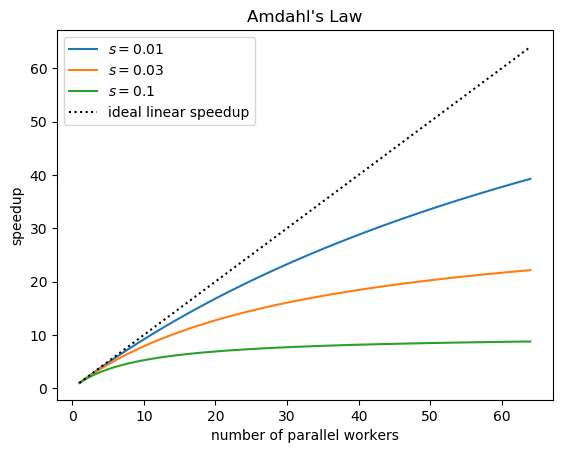

In [8]:
machine_numbers = collect(1:64);
for serial_fraction in [0.01,0.03,0.1]
    speedups = 1.0 ./ (serial_fraction .+ (1 - serial_fraction)./machine_numbers);
    plot(machine_numbers, speedups; label="\$s = $serial_fraction\$");
end
plot(machine_numbers, machine_numbers; linestyle=":", c="k", label="ideal linear speedup")
xlabel("number of parallel workers"); ylabel("speedup"); title("Amdahl's Law"); legend();

### Summary: four types of parallelism common on CPUs.

* Instruction level parallelism (ILP): run multiple instructions simultaneously.

* Single-instruction multiple-data parallelism (SIMD): a single special instruction operates on a vector of numbers.

* Multi-thread parallelism: multiple independent worker threads collaborate over a shared-memory abstraction.

* Distributed computing: multiple independent worker machines collaborate over a network.

* ...and programs usually need to be written to take advantage of these parallel features of the hardware.

<div class="demo">DEMO</div>

### A simple example of how writing code in a way that takes parallelism into account can affect performance

In [13]:
n = 1024;
m = 1024;
p = 1024;

A = randn(Float32,m,n);
B = randn(Float32,n,p);

# array to hold result of multiply
C = zeros(Float32,m,p);

In [14]:
@time mul!(C, A, B);

  0.011244 seconds


In [15]:
function my_mul!(C::Matrix{Float32}, A::Matrix{Float32}, B::Matrix{Float32})
    (m,n) = size(A);
    (n,p) = size(B);
    for i = 1:m
        for k = 1:p
            acc = 0.0;
            for j = 1:n
                acc += A[i,j] * B[j,k];
            end
            C[i,k] = acc;
        end
    end
    return C;
end

my_mul! (generic function with 1 method)

In [18]:
@time my_mul!(C, A, B);

  1.979788 seconds


### What happened?

Why was the function I wrote so slow? Isn't this just doing matrix multiply?

You might blame the Julia compiler...so lets use a language that everyone believes is efficient: **C**.


<!-- Generator: GNU source-highlight 3.1.8
by Lorenzo Bettini
http://www.lorenzobettini.it
http://www.gnu.org/software/src-highlite -->
<pre><tt>
<b><font color="#000080">#include</font></b> <font color="#FF0000">&lt;stdlib.h&gt;</font>
<b><font color="#000080">#include</font></b> <font color="#FF0000">&lt;stdio.h&gt;</font>
<b><font color="#000080">#include</font></b> <font color="#FF0000">&lt;math.h&gt;</font>
<b><font color="#000080">#include</font></b> <font color="#FF0000">&lt;time.h&gt;</font>
<b><font color="#000080">#include</font></b> <font color="#FF0000">&lt;sys/time.h&gt;</font>
<b><font color="#000080">#include</font></b> <font color="#FF0000">&lt;cblas.h&gt;</font>

<font color="#009900">int</font> <b><font color="#000000">main</font></b><font color="#990000">(</font><font color="#009900">int</font> argc<font color="#990000">,</font> <font color="#009900">char</font><font color="#990000">*</font> argv<font color="#990000">[])</font> <font color="#FF0000">{</font>
	<b><font color="#0000FF">if</font></b> <font color="#990000">(</font>argc <font color="#990000">!=</font> <font color="#993399">5</font><font color="#990000">)</font> <font color="#FF0000">{</font>
		<b><font color="#000000">printf</font></b><font color="#990000">(</font><font color="#FF0000">"error: need four arguments!</font><font color="#CC33CC">\n</font><font color="#FF0000">"</font><font color="#990000">);</font>
		<b><font color="#0000FF">return</font></b> <font color="#993399">1</font><font color="#990000">;</font>
	<font color="#FF0000">}</font>

<b><font color="#000080">	#ifdef</font></b> USE_BLAS
<b><font color="#000080">	#ifdef</font></b> BLAS_ONE_THREAD
		<b><font color="#000000">openblas_set_num_threads</font></b><font color="#990000">(</font><font color="#993399">1</font><font color="#990000">);</font>
<b><font color="#000080">	#else</font></b>
		<b><font color="#000000">openblas_set_num_threads</font></b><font color="#990000">(</font><font color="#993399">4</font><font color="#990000">);</font>
<b><font color="#000080">	#endif</font></b>
<b><font color="#000080">	#endif</font></b>

	<font color="#009900">int</font> m <font color="#990000">=</font> <b><font color="#000000">atoi</font></b><font color="#990000">(</font>argv<font color="#990000">[</font><font color="#993399">1</font><font color="#990000">]);</font>
	<font color="#009900">int</font> n <font color="#990000">=</font> <b><font color="#000000">atoi</font></b><font color="#990000">(</font>argv<font color="#990000">[</font><font color="#993399">2</font><font color="#990000">]);</font>
	<font color="#009900">int</font> p <font color="#990000">=</font> <b><font color="#000000">atoi</font></b><font color="#990000">(</font>argv<font color="#990000">[</font><font color="#993399">3</font><font color="#990000">]);</font>
	<font color="#009900">int</font> num_runs <font color="#990000">=</font> <b><font color="#000000">atoi</font></b><font color="#990000">(</font>argv<font color="#990000">[</font><font color="#993399">4</font><font color="#990000">]);</font>

	<font color="#009900">float</font><font color="#990000">*</font> A <font color="#990000">=</font> <b><font color="#000000">malloc</font></b><font color="#990000">(</font><b><font color="#0000FF">sizeof</font></b><font color="#990000">(</font><font color="#009900">float</font><font color="#990000">)</font> <font color="#990000">*</font> m <font color="#990000">*</font> n<font color="#990000">);</font>
	<font color="#009900">float</font><font color="#990000">*</font> B <font color="#990000">=</font> <b><font color="#000000">malloc</font></b><font color="#990000">(</font><b><font color="#0000FF">sizeof</font></b><font color="#990000">(</font><font color="#009900">float</font><font color="#990000">)</font> <font color="#990000">*</font> n <font color="#990000">*</font> p<font color="#990000">);</font>
	<font color="#009900">float</font><font color="#990000">*</font> C <font color="#990000">=</font> <b><font color="#000000">malloc</font></b><font color="#990000">(</font><b><font color="#0000FF">sizeof</font></b><font color="#990000">(</font><font color="#009900">float</font><font color="#990000">)</font> <font color="#990000">*</font> m <font color="#990000">*</font> p<font color="#990000">);</font>

	<b><font color="#0000FF">for</font></b> <font color="#990000">(</font><font color="#009900">int</font> i <font color="#990000">=</font> <font color="#993399">0</font><font color="#990000">;</font> i <font color="#990000">&lt;</font> m<font color="#990000">;</font> i<font color="#990000">++)</font> <font color="#FF0000">{</font>
		<b><font color="#0000FF">for</font></b> <font color="#990000">(</font><font color="#009900">int</font> j <font color="#990000">=</font> <font color="#993399">0</font><font color="#990000">;</font> j <font color="#990000">&lt;</font> n<font color="#990000">;</font> j<font color="#990000">++)</font> <font color="#FF0000">{</font>
			A<font color="#990000">[</font>i<font color="#990000">*</font>n <font color="#990000">+</font> j<font color="#990000">]</font> <font color="#990000">=</font> <b><font color="#000000">rand</font></b><font color="#990000">();</font>
		<font color="#FF0000">}</font>
	<font color="#FF0000">}</font>

	<b><font color="#0000FF">for</font></b> <font color="#990000">(</font><font color="#009900">int</font> j <font color="#990000">=</font> <font color="#993399">0</font><font color="#990000">;</font> j <font color="#990000">&lt;</font> n<font color="#990000">;</font> j<font color="#990000">++)</font> <font color="#FF0000">{</font>
		<b><font color="#0000FF">for</font></b> <font color="#990000">(</font><font color="#009900">int</font> k <font color="#990000">=</font> <font color="#993399">0</font><font color="#990000">;</font> k <font color="#990000">&lt;</font> p<font color="#990000">;</font> k<font color="#990000">++)</font> <font color="#FF0000">{</font>
			B<font color="#990000">[</font>j<font color="#990000">*</font>p <font color="#990000">+</font> k<font color="#990000">]</font> <font color="#990000">=</font> <b><font color="#000000">rand</font></b><font color="#990000">();</font>
		<font color="#FF0000">}</font>
	<font color="#FF0000">}</font>

	<b><font color="#0000FF">for</font></b> <font color="#990000">(</font><font color="#009900">int</font> i <font color="#990000">=</font> <font color="#993399">0</font><font color="#990000">;</font> i <font color="#990000">&lt;</font> m<font color="#990000">;</font> i<font color="#990000">++)</font> <font color="#FF0000">{</font>
		<b><font color="#0000FF">for</font></b> <font color="#990000">(</font><font color="#009900">int</font> k <font color="#990000">=</font> <font color="#993399">0</font><font color="#990000">;</font> k <font color="#990000">&lt;</font> p<font color="#990000">;</font> k<font color="#990000">++)</font> <font color="#FF0000">{</font>
			C<font color="#990000">[</font>i<font color="#990000">*</font>p <font color="#990000">+</font> k<font color="#990000">]</font> <font color="#990000">=</font> <font color="#993399">0.0</font><font color="#990000">;</font>
		<font color="#FF0000">}</font>
	<font color="#FF0000">}</font>

	<font color="#009900">double</font> average_time <font color="#990000">=</font> <font color="#993399">0.0</font><font color="#990000">;</font>
	<b><font color="#0000FF">for</font></b> <font color="#990000">(</font><font color="#009900">int</font> iters <font color="#990000">=</font> <font color="#993399">0</font><font color="#990000">;</font> iters <font color="#990000">&lt;</font> num_runs<font color="#990000">;</font> iters<font color="#990000">++)</font> <font color="#FF0000">{</font>
		<font color="#009900">double</font> cpu_time_used<font color="#990000">;</font>

		<font color="#009900">long</font> start<font color="#990000">,</font> end<font color="#990000">;</font>
    	<b><font color="#0000FF">struct</font></b> <font color="#008080">timeval</font> timecheck<font color="#990000">;</font>

    	<b><font color="#000000">gettimeofday</font></b><font color="#990000">(&amp;</font>timecheck<font color="#990000">,</font> NULL<font color="#990000">);</font>
    	start <font color="#990000">=</font> <font color="#990000">(</font><font color="#009900">long</font><font color="#990000">)</font>timecheck<font color="#990000">.</font>tv_sec <font color="#990000">*</font> <font color="#993399">1000</font> <font color="#990000">+</font> <font color="#990000">(</font><font color="#009900">long</font><font color="#990000">)</font>timecheck<font color="#990000">.</font>tv_usec <font color="#990000">/</font> <font color="#993399">1000</font><font color="#990000">;</font>

<b><font color="#000080">	#ifndef</font></b> USE_BLAS
		<b><font color="#0000FF">for</font></b> <font color="#990000">(</font><font color="#009900">int</font> i <font color="#990000">=</font> <font color="#993399">0</font><font color="#990000">;</font> i <font color="#990000">&lt;</font> m<font color="#990000">;</font> i<font color="#990000">++)</font> <font color="#FF0000">{</font>
	        <b><font color="#0000FF">for</font></b> <font color="#990000">(</font><font color="#009900">int</font> j <font color="#990000">=</font> <font color="#993399">0</font><font color="#990000">;</font> j <font color="#990000">&lt;</font> n<font color="#990000">;</font> j<font color="#990000">++)</font> <font color="#FF0000">{</font>
	        	<b><font color="#0000FF">for</font></b> <font color="#990000">(</font><font color="#009900">int</font> k <font color="#990000">=</font> <font color="#993399">0</font><font color="#990000">;</font> k <font color="#990000">&lt;</font> p<font color="#990000">;</font> k<font color="#990000">++)</font> <font color="#FF0000">{</font>
	                C<font color="#990000">[</font>i<font color="#990000">*</font>p <font color="#990000">+</font> k<font color="#990000">]</font> <font color="#990000">+=</font> A<font color="#990000">[</font>i<font color="#990000">*</font>n <font color="#990000">+</font> j<font color="#990000">]</font> <font color="#990000">*</font> B<font color="#990000">[</font>j<font color="#990000">*</font>p <font color="#990000">+</font> k<font color="#990000">];</font>
	            <font color="#FF0000">}</font>
	        <font color="#FF0000">}</font>
	    <font color="#FF0000">}</font>
<b><font color="#000080">	#else</font></b>
		<b><font color="#000000">cblas_sgemm</font></b><font color="#990000">(</font>CblasRowMajor<font color="#990000">,</font> CblasNoTrans<font color="#990000">,</font> CblasNoTrans<font color="#990000">,</font> m<font color="#990000">,</font> p<font color="#990000">,</font> n<font color="#990000">,</font> <font color="#993399">1.0</font><font color="#990000">,</font> A<font color="#990000">,</font> n<font color="#990000">,</font> B<font color="#990000">,</font> p<font color="#990000">,</font> <font color="#993399">0.0</font><font color="#990000">,</font> C<font color="#990000">,</font> p<font color="#990000">);</font>
<b><font color="#000080">	#endif</font></b>

	    <b><font color="#000000">gettimeofday</font></b><font color="#990000">(&amp;</font>timecheck<font color="#990000">,</font> NULL<font color="#990000">);</font>
	    end <font color="#990000">=</font> <font color="#990000">(</font><font color="#009900">long</font><font color="#990000">)</font>timecheck<font color="#990000">.</font>tv_sec <font color="#990000">*</font> <font color="#993399">1000</font> <font color="#990000">+</font> <font color="#990000">(</font><font color="#009900">long</font><font color="#990000">)</font>timecheck<font color="#990000">.</font>tv_usec <font color="#990000">/</font> <font color="#993399">1000</font><font color="#990000">;</font>

	    cpu_time_used <font color="#990000">=</font> <font color="#990000">(</font>end <font color="#990000">-</font> start<font color="#990000">)*</font><font color="#993399">0.001</font><font color="#990000">;</font>
	    average_time <font color="#990000">+=</font> cpu_time_used<font color="#990000">;</font>

	    <b><font color="#000000">printf</font></b><font color="#990000">(</font><font color="#FF0000">"time elapsed: %f seconds</font><font color="#CC33CC">\n</font><font color="#FF0000">"</font><font color="#990000">,</font> cpu_time_used<font color="#990000">);</font>
	<font color="#FF0000">}</font>

	<b><font color="#000000">printf</font></b><font color="#990000">(</font><font color="#FF0000">"</font><font color="#CC33CC">\n</font><font color="#FF0000">average time: %lf seconds</font><font color="#CC33CC">\n\n</font><font color="#FF0000">"</font><font color="#990000">,</font> average_time <font color="#990000">/</font> num_runs<font color="#990000">);</font>

    <font color="#009900">float</font> rv <font color="#990000">=</font> <font color="#993399">0.0</font><font color="#990000">;</font>
    <b><font color="#0000FF">for</font></b> <font color="#990000">(</font><font color="#009900">int</font> i <font color="#990000">=</font> <font color="#993399">0</font><font color="#990000">;</font> i <font color="#990000">&lt;</font> m<font color="#990000">;</font> i<font color="#990000">++)</font> <font color="#FF0000">{</font>
		<b><font color="#0000FF">for</font></b> <font color="#990000">(</font><font color="#009900">int</font> k <font color="#990000">=</font> <font color="#993399">0</font><font color="#990000">;</font> k <font color="#990000">&lt;</font> p<font color="#990000">;</font> k<font color="#990000">++)</font> <font color="#FF0000">{</font>
			rv <font color="#990000">+=</font> C<font color="#990000">[</font>i<font color="#990000">*</font>p <font color="#990000">+</font> k<font color="#990000">];</font>
		<font color="#FF0000">}</font>
	<font color="#FF0000">}</font>

   	<b><font color="#000000">printf</font></b><font color="#990000">(</font><font color="#FF0000">"digest: %e</font><font color="#CC33CC">\n</font><font color="#FF0000">"</font><font color="#990000">,</font> rv<font color="#990000">);</font>

    <b><font color="#000000">free</font></b><font color="#990000">(</font>A<font color="#990000">);</font>
    <b><font color="#000000">free</font></b><font color="#990000">(</font>B<font color="#990000">);</font>
    <b><font color="#000000">free</font></b><font color="#990000">(</font>C<font color="#990000">);</font>

    <b><font color="#0000FF">return</font></b> <font color="#993399">0</font><font color="#990000">;</font>
<font color="#FF0000">}</font></tt></pre>

### What does this mean for machine learning?

In order to optimize the ML pipeline, we need to reason about how we can best use parallelism at each stage.
Since we've been talking about training for most of the class, let's look at how we can use these types of parallelism to accelerate training an ML model.


### Using parallelism to make linear algebra fast.

We can get a major boost in performance by building linear algebra kernels (e.g. matrix multiplies, vector adds, et cetera) that use parallelism to run fast.

Since matrix multiplies represent most of the computation of training a deep neual network, this can result in a major end-to-end speedup of the training pipeline.

This mostly involves ILP and SIMD parallelism, and (for larger matrices) it can also use multi-threading.

### Using parallelism within an iteration of SGD.

* Computing gradients within a batch
* Linear algebra operations to compute gradients

### Using parallelism in hyperparameter optimization.

* Run multiple evaluations in parallel
  * For grid search, run each element of the grid on its parallel machine. (DISTRIBUTED)
* Cross-validation

### Using parallelism elsewhere in the ML pipeline.

* Preprocessing/loading the data
* Feature extraction (often)
* Inference
  * Want to produce predictions for many examples? We can do this in paralle on many machines!

### Takeaway: there's lots of opportunities to help machine learning scale by using parallelism.

Existing ML frameworks do a lot of this automatically for common tasks like deep learning training, and we'll talk about how they do it, as well as about other more advanced ways of using parallelism, in the next lecture.